## Loading libraries

In [4]:
import pandas as pd
import numpy as np
import re
import sklearn 
import xgboost as xgb        
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [7]:
import warnings
warnings.filterwarnings('ignore')

## Now import the 5 base models for the stacking

In [8]:
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier,
                              GradientBoostingClassifier,ExtraTreesClassifier)

In [9]:
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

## Moving ahead to feature exploration, cleaning and engineering


In [10]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [15]:
train.head(2)
# train.tail(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [30]:
# print(train.describe)
train.describe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Now a little bit of data cleaning

In [18]:
full_data = [train,test]

In [32]:
complete = pd.concat([train,test],axis=0)

In [35]:
complete.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket'],
      dtype='object')

In [38]:
train['Pclass'].value_counts()


3    491
1    216
2    184
Name: Pclass, dtype: int64

### Highest number of passengers in Class 3

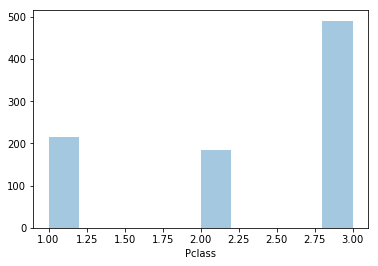

In [40]:
sns.distplot(train['Pclass'],kde=False)

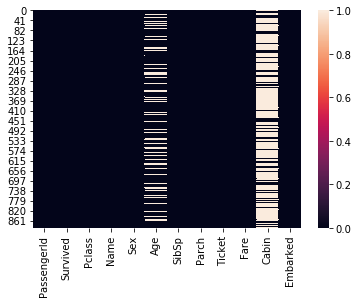

In [44]:
sns.heatmap(train.isnull())

### Feature Engineering

In [54]:
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ""

# for dataset in full_data:
#     print(dataset['Name'].apply(get_title).value_counts())

sex_encoding = {'male':1,'female':0}

In [65]:

for dataset in full_data:
    
    #Feature tells the length of the name of the person
    dataset['Name_length'] = dataset['Name'].apply(len)
    
    # Feature tells if person has cabin or not
    dataset['Has_Cabin'] = dataset['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    
    # Creating Family size from Siblings and Parch
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    # Removing nulls from Embarked
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
    # Imputing nulls from Fare with the median Fare value
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    
    # Imputing Age with Normal Distribution of Age
    age_avg,age_std = dataset['Age'].mean() ,dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint((age_avg - age_std),(age_avg + age_std),size = age_null_count)
    
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
    # Getting Title from name
    dataset['Title'] = dataset['Name'].apply(get_title)
    # Replacing the Rare titles with 'rare'
    dataset['Title'] = dataset['Title'].replace(['Rev','Mlle','Major','Col','Countess','Sir','Mme','Don','Lady','Capt','Jonkheer'],'rare')
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms'],'Miss')
    dataset['Title'] = dataset['Title'].replace(['Mme','Mrs'],'Mrs')
    
    dataset['Sex'] = dataset['Sex'].apply(lambda x: sex_encoding[x])
    
    dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    
    # Mapping fare - Descritization
    dataset.loc[dataset['Fare'] <= 7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.545),'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.545) & (dataset['Fare'] <= 31 ),'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 31 ),'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,0,NaN,0,23,0,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,3,C85,1,51,1,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,1,NaN,0,22,0,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,3,C123,0,44,1,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,1,NaN,0,24,0,1,Mr
5,6,0,3,"Moran, Mr. James",1,23,0,0,330877,1,NaN,2,16,0,1,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",1,54,0,0,17463,3,E46,0,23,1,1,Mr
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27,0,2,347742,1,NaN,0,49,0,3,Mrs
11,12,1,1,"Bonnell, Miss. Elizabeth",0,58,0,0,113783,2,C103,0,24,1,1,Miss
12,13,0,3,"Saundercock, Mr. William Henry",1,20,0,0,A/5. 2151,1,NaN,0,30,0,1,Mr
